In [1]:
!pip install earthpy gdal

     |████████████████████████████████| 1.4 MB 14.5 MB/s 
     |████████████████████████████████| 1.0 MB 73.3 MB/s 
     |████████████████████████████████| 19.3 MB 510 kB/s 
     |████████████████████████████████| 6.3 MB 56.0 MB/s 
     |████████████████████████████████| 15.4 MB 57.4 MB/s 


In [2]:
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score
import plotly.graph_objects as go


In [5]:
%cd /content/drive/MyDrive/Satellite_data

/content/drive/MyDrive/Satellite_data


Read the data from your drive

In [6]:
bands = glob("/content/drive/MyDrive/Satellite_data/sundarbans_data/*B?*.tiff")

In [7]:
bands.sort()
bands

['/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/content/drive/MyDrive

In [8]:
dl = []
for j in bands:
  with rio.open(j,'r') as s:
    dl.append(s.read(1))

In [9]:
stack_array = np.stack(dl)

In [10]:
#See if the data has been read perfectly
print(f'Width: {stack_array.shape[2]}\nHeight: {stack_array.shape[1]}\nBands: {stack_array.shape[0]}')

Width: 298
Height: 954
Bands: 12


Lets visualize the data using earthpy.plot and matplotlib.pyplot

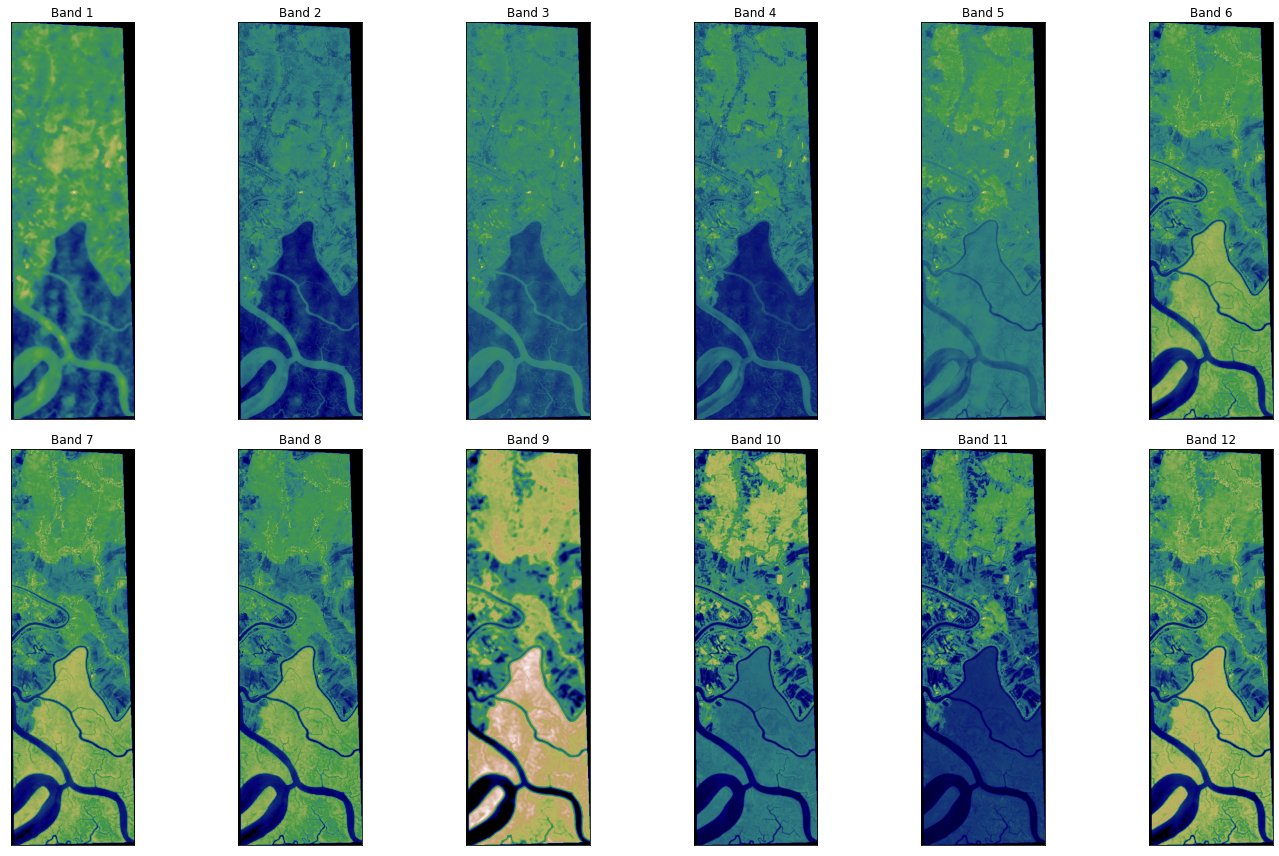

In [11]:
ep.plot_bands(stack_array, cmap = 'gist_earth', figsize = (20, 12), cols=6, cbar=False)
plt.show()

Construct the equivalent RGB composite image using earthpy.plot and matplotlib.pyplot

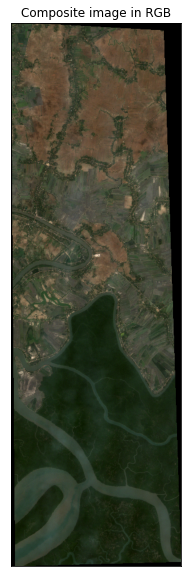

In [12]:
img = ep.plot_rgb(stack_array, rgb = (3,2,1), figsize= (8,10), title="Composite image in RGB")
plt.show()

#if you want to visualize the stretched image you can use the following command, uncomment it to run.
#ep.plot_rgb(stack_array, rgb=(3,2,1), stretch = True, str_clip=0.4, figsize = (8,10), title = "Stretched composite image in RGB")
#plt.show()

Visualize the band distribution in your dataset

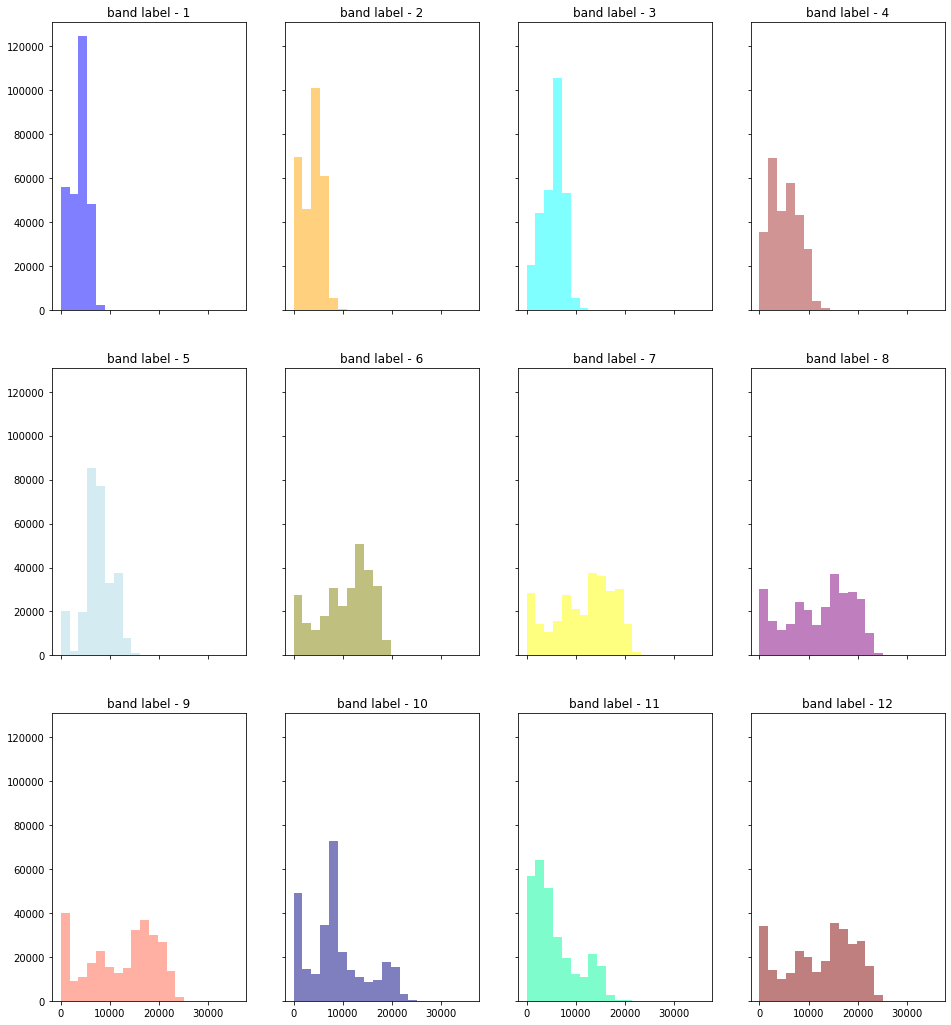

In [15]:
band_colors = ['blue', 'orange', 'cyan', 'brown', 'lightblue', 'olive', 'yellow', 'purple', 'tomato', 'navy', 'MediumSpringGreen', 'maroon']
ep.hist(stack_array, colors= band_colors, title = [f'band label - {k}' for k in range(1,13)], cols = 4, alpha = 0.5, figsize = (16,18))
plt.show()

Preprocess your dataset 

In [16]:
pd = np.moveaxis(stack_array, 0, -1)
pd.shape

(954, 298, 12)

In [18]:
from sklearn.preprocessing import StandardScaler
data_pd = pd.reshape(-1, 12)
scaled_fit = StandardScaler().fit(data_pd)
data_scaled = scaled_fit.transform(data_pd)
data_scaled.shape

(284292, 12)

Load the groundtruth values from the dataset

In [20]:
labels = loadmat('/content/drive/MyDrive/Satellite_data/sundarbans_data/Sundarbands_gt.mat')['gt']
labels.shape

(954, 298)

Visualize the groundtruth using earthpy.plot and matplotlib.pyplot

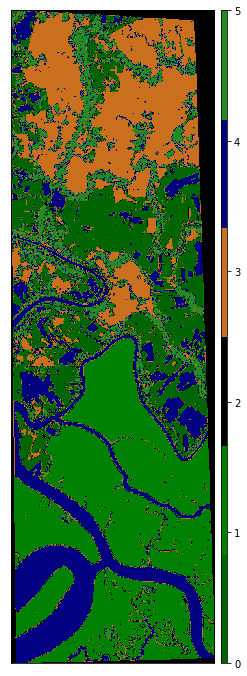

In [21]:
ep.plot_bands(labels, cmap=ListedColormap(['darkgreen', 'green','black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

Splitting the dataset into trainingset and testset

In [22]:
from sklearn.model_selection import train_test_split

trainset, testset, trainlabel, testlabel = train_test_split(data_scaled, labels.ravel(), test_size = 0.30, stratify = labels.ravel())

print(f'trainset shape: {trainset.shape}\ntestset shape: {testset.shape}\nlabel_train shape: {trainlabel.shape}\nlabel_test shape:{testlabel.shape}')

trainset shape: (199004, 12)
testset shape: (85288, 12)
label_train shape: (199004,)
label_test shape:(85288,)


Train the dataset using Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier()
mdl.fit(trainset, trainlabel)

mdl_pred = mdl.predict(testset)

In [ ]:
Print the Test Accuracy

In [24]:
print(f"Test Accuracy: {accuracy_score(testlabel, mdl_pred)*100}")

Test Accuracy: 99.00454929181127


Prediction Stats using Classification Report

In [25]:
print(classification_report(testlabel, mdl_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16222
           1       1.00      1.00      1.00     23570
           2       1.00      1.00      1.00      6095
           3       0.99      0.99      0.99     16790
           4       0.99      0.99      0.99     13545
           5       0.97      0.97      0.97      9066

    accuracy                           0.99     85288
   macro avg       0.99      0.99      0.99     85288
weighted avg       0.99      0.99      0.99     85288



Visualize the classification results on image using earthpy.plot and matplotlib

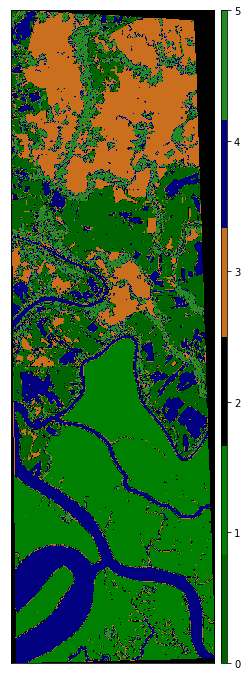

In [26]:
ep.plot_bands(mdl.predict(data_scaled).reshape((954, 298)), cmap = ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

You can train with other machine learning algorithms such as Support Vector Machines (from sklearn.svm import svc, svm = SVC(), svm.fit(trainset, trainlabels). For K-Nearest Neighbor use (from sklearn.neighbors import KNeighborsClassifier, knn = KNeighborsClassifier(number_of_neighbors), knn.fit(trainset, trainlabels). For Light BGM use, import lightgbm as lgb, gradient_boosting = lgb.Dataset(trainset, label=trainlabels), params = {}, params['learning_rate'] = value, params['boosting_type'] = 'gbdt' #gradientboostingdecisiontree, params['objective'] = 'multiclass', params['metric'] = 'multi_logloss', params['max_depth'] = number_of_trees #(int value), params['num_class'] = 6
mdl_lgb = lgb.train(params, gradient_boosting, 100) 